# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

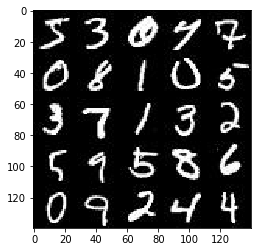

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

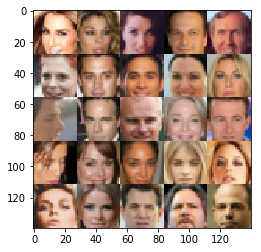

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/parijatrathore/miniconda2/envs/dlnd-tf-lab/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1,x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.1
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)* 
                                                                         (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    # Optimize

    with tf.control_dependencies(gen_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    dis_updates = [op for op in update_ops if op.name.startswith('discriminator')] 
    with tf.control_dependencies(dis_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _ , image_width, image_height, image_channels = data_shape
    image_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(image_input, z_input, len(data_image_mode))
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                steps +=1
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, image_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5279... Generator Loss: 0.2171
Epoch 1/2... Discriminator Loss: 1.9982... Generator Loss: 0.5087
Epoch 1/2... Discriminator Loss: 2.0003... Generator Loss: 0.3850
Epoch 1/2... Discriminator Loss: 2.1665... Generator Loss: 0.3378
Epoch 1/2... Discriminator Loss: 1.9705... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.8198... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 1.6313... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.6168... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.8391


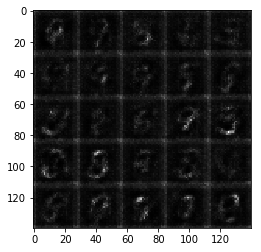

Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.5888
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.7264
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.6802


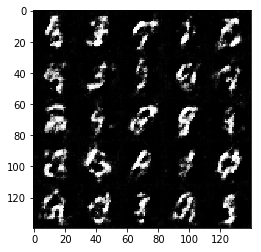

Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.6593
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 1.0316
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 1.0802
Epoch 1/2... Discriminator Loss: 1.3383... Generator Loss: 0.9442
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.9633
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.6505


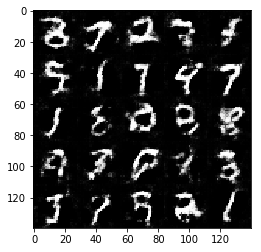

Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.7214
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.5797... Generator Loss: 0.4321
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.9480
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.6876
Epoch 1/2... Discriminator Loss: 1.3896... Generator Loss: 0.6724
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.6313


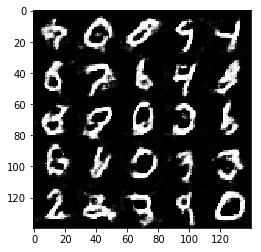

Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.4952... Generator Loss: 1.1074
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.6555
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 1.4221... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.4410... Generator Loss: 0.5994


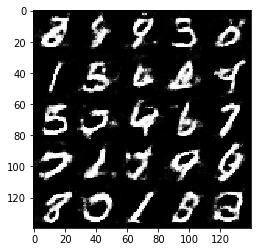

Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.6506
Epoch 2/2... Discriminator Loss: 1.5250... Generator Loss: 0.4829
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.5659
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.9719
Epoch 2/2... Discriminator Loss: 1.3589... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 1.3855... Generator Loss: 0.8155
Epoch 2/2... Discriminator Loss: 1.4392... Generator Loss: 0.6217
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.7735


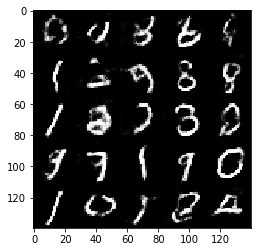

Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.5413
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.4688
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.5584... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.9913
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 1.0434
Epoch 2/2... Discriminator Loss: 1.3291... Generator Loss: 0.6916


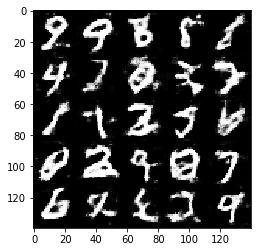

Epoch 2/2... Discriminator Loss: 1.3666... Generator Loss: 0.6102
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.8342
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.3744... Generator Loss: 0.6852
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.6958
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.6168
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.6070
Epoch 2/2... Discriminator Loss: 1.4280... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.9676


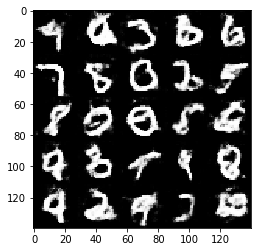

Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.8655
Epoch 2/2... Discriminator Loss: 1.3258... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 1.0448
Epoch 2/2... Discriminator Loss: 1.4923... Generator Loss: 0.5043
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.7197
Epoch 2/2... Discriminator Loss: 1.4879... Generator Loss: 0.5719
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.9311
Epoch 2/2... Discriminator Loss: 1.4161... Generator Loss: 0.5808
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 1.3030


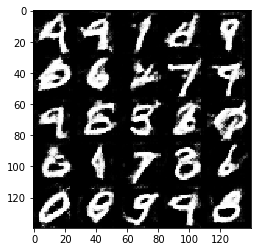

Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.6704
Epoch 2/2... Discriminator Loss: 1.3620... Generator Loss: 0.6964


In [25]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.6343... Generator Loss: 0.0689
Epoch 1/1... Discriminator Loss: 2.5291... Generator Loss: 0.2048
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.8352... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.9242... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 2.0053... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 2.0379... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.8997... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.8208... Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.9371... Generator Loss: 0.5095


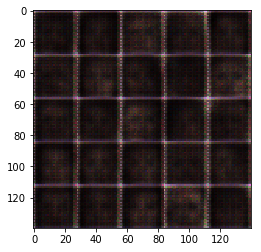

Epoch 1/1... Discriminator Loss: 1.8241... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7855


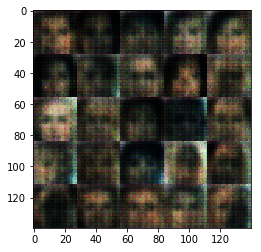

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.7391... Generator Loss: 0.3789
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.6717
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.7495


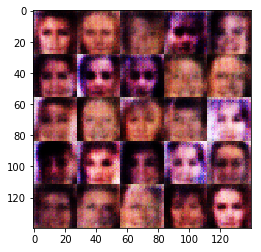

Epoch 1/1... Discriminator Loss: 1.6400... Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.8366... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 1.7504
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.6473... Generator Loss: 0.5892


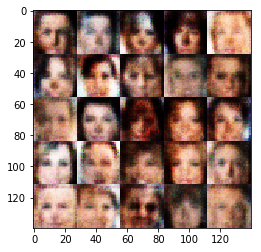

Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.9702
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.7954
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.5216


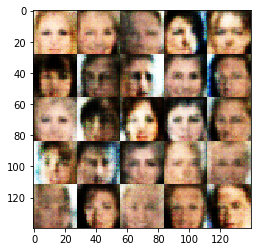

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 1.0887
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.6074
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6503


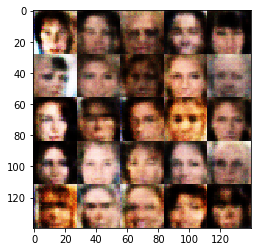

Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.8535
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 1.1569


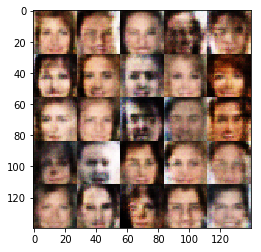

Epoch 1/1... Discriminator Loss: 1.5643... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6752


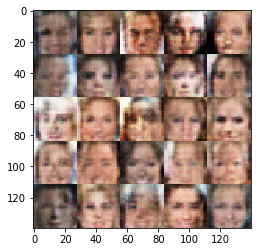

Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7463


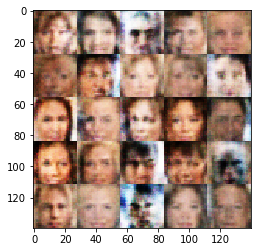

Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.5417... Generator Loss: 0.7055


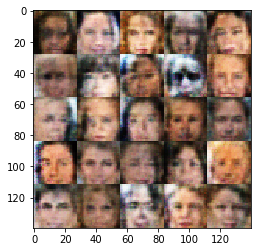

Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7348


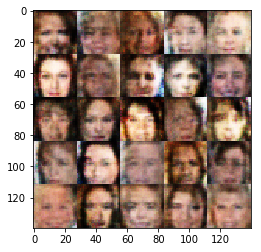

Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7447


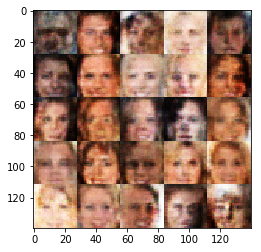

Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7540


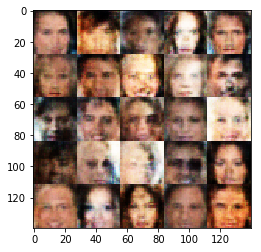

Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7333


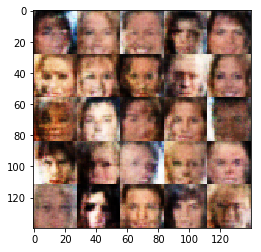

Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7743


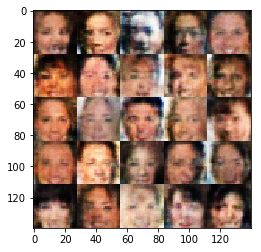

Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7825


In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.